In [10]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import copy


x_col = ['text', 'datetime', 'retweet_count', 'favorite_count', 'place_full_name']
y_col = ['who']

# comma delimited is the default
#df = pd.read_csv(input_file, header = 0)
X_train = pd.read_csv('tweets/tweets-train-data.csv', names = x_col)
y_train = pd.read_csv('tweets/tweets-train-targets.csv', names = y_col)
X_train = X_train.drop('datetime', 1)
X_train = X_train.drop('place_full_name', 1)


X_test = pd.read_csv('tweets/tweets-test-data.csv', names = x_col)
y_test = pd.read_csv('tweets/tweets-test-targets.csv', names = y_col)
X_test = X_test.drop('datetime', 1)
X_test = X_test.drop('place_full_name', 1)

X_test.head()


# Let's check the length of the two sets
#len(X_train), len(X_test)

,text,retweet_count,favorite_count
0,we dont know why trump and putin praise each o...,7475,11964
1,is really starting to campaign hard for marcor...,1687,4672
2,find out where to on caucus night in iowa on 2116,1556,3504
3,100 true gt is right did call tpp the gold s...,7419,12728
4,i took trump university class and saved my home,2879,7931


In [4]:
#Change HC -> 0 and DT ->1 into the y dataframes.
dict = {'HC': 0, 'DT': 1}

y_train = y_train.replace({"who": dict})
y_train.head()

y_test = y_test.replace({"who": dict})
y_test.head()


,who
0,0
1,1
2,1
3,1
4,1


In [17]:
#Extract features from tweets
'''from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
x_features_train = tfidf.fit_transform(X_train.text).toarray()

x_features_test = tfidf.fit_transform(X_test.text).toarray()'''

# Feature extraction from text
# Method: bag of words 
# https://pythonprogramminglanguage.com

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

x_features = vectorizer.fit_transform(X_train.text, X_test.text) 
#print( vectorizer.vocabulary_ )

#x_features_test = vectorizer.fit_transform(X_test.text)


/home/filippo/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


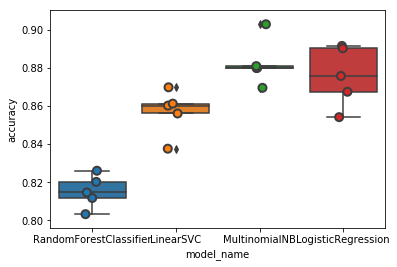

model_name
LinearSVC                 0.857023
LogisticRegression        0.875852
MultinomialNB             0.882674
RandomForestClassifier    0.815227
Name: accuracy, dtype: float64

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, x_features, y_train.values.ravel(), scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()


In [16]:
model = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(x_features_train, y_train)
y_pred = model.predict(x_features_test)
y_pred

#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


from sklearn import metrics
report = metrics.classification_report(y_test.values, y_pred)
print(report)





/home/filippo/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: X has 3941 features per sample; expecting 6883